In [27]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.optimizers import Adam
import cv2
from tensorflow.keras.preprocessing import image
import keras
# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
import numpy as np

In [29]:
# Fonction pour redimensionner, normaliser et prétraiter une image pour VGG16
def preprocess_image_efficientB0(img_path, target_size=(224, 224)):
    # Charger l'image depuis le chemin du fichier en couleur
    img = cv2.imread(img_path)
    # Redimensionner l'image à la taille cible pour EfficientNetB0
    img_resized = cv2.resize(img, target_size)
    # Prétraiter l'image pour EfficientNetB0
    img_preprocessed = preprocess_input(img_resized)
    return img_preprocessed

# Chemin vers vos dossiers contenant les images saines et malades
pneumo_folder_path = "../../data/raw/datasets/Covid-19_MC_600_Dataset_All/Viral_Pneumonia" #0
lo_folder_path = "../../data/raw/datasets/Covid-19_MC_600_Dataset_All/Lung_Opacity" # 1
normal_folder_path = "../../data/raw/datasets/Covid-19_MC_600_Dataset_All/Normal" #2
covid_folder_path = "../../data/raw/datasets/Covid-19_MC_600_Dataset_All/COVID" #3
# :{0: 'Viral_Pneumonia', 1: 'Lung_Opacity', 2: 'Normal', 3: 'COVID'}
# Liste pour stocker les données d'images et les étiquettes
images_data = []
labels = []

# Parcourez le dossier contenant les images Pneumonie Virale et les labelliser à 0
for filename in os.listdir(pneumo_folder_path):
    # Construire le chemin complet de l'image
    img_path = os.path.join(pneumo_folder_path, filename)
    # Prétraiter l'image et l'ajouter à la liste des données d'images
    images_data.append(preprocess_image_efficientB0(img_path))
    # Étiquettez les images 
    labels.append(0)

# Parcourez le dossier contenant les images Lung Opacity et les labelliser à 1
for filename in os.listdir(lo_folder_path):
    img_path = os.path.join(lo_folder_path, filename)
    # Prétraiter l'image et l'ajouter à la liste des données d'images
    images_data.append(preprocess_image_efficientB0(img_path))
    # Étiquettez les images 
    labels.append(1)

# Parcourez le dossier contenant les images Normal et les labelliser à 2
for filename in os.listdir(normal_folder_path):
    img_path = os.path.join(normal_folder_path, filename)
    # Prétraiter l'image et l'ajouter à la liste des données d'images
    images_data.append(preprocess_image_efficientB0(img_path))
    # Étiquettez les images 
    labels.append(2)

# Parcourez le dossier contenant les images COVID et les labelliser à 3
for filename in os.listdir(covid_folder_path):
    img_path = os.path.join(covid_folder_path, filename)
    # Prétraiter l'image et l'ajouter à la liste des données d'images
    images_data.append(preprocess_image_efficientB0(img_path))
    # Étiquettez les images 
    labels.append(3)

# Conversion des données
images_data = np.array(images_data)
labels = np.array(labels)

# Division des données en ensembles d'entraînement et de test
x_train, x_val, y_train, y_val = train_test_split(images_data, labels, test_size=0.2, random_state=42)

# One hot encoding
num_classes = 4  # Set this to the number of classes in your dataset
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

#print(y_val)

In [ ]:
from keras import regularizers
from keras.regularizers import l1


# Définition de la fonction de construction de modèle pour Keras Tuner
# Keras Tuner: Learning rate, Couche Dense, Dropout et Droupout connect rate spécifique à EfficientNet, et learning rate pour la régularisation
def build_model(hp):
    # Hyperparamètres à rechercher
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4,1e-5])
    units = hp.Int('units', min_value=32, max_value=512, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    dropout_connect_rate = hp.Float('dropout_connect_rate', min_value=0.2, max_value=0.4, step=0.1)
    l2_lambda = hp.Choice('l2_lambda', values=[1e-3, 1e-4, 1e-5])  # Hyperparamètre pour la régularisation L2

    # Chargement du modèle EfficientNetB0 pré-entraîné
    base_model = EfficientNetB0(include_top=False, weights="imagenet", drop_connect_rate=dropout_connect_rate)
    # Dégel des dernières couches de convolution
    for layer in base_model.layers[-20:]:
            if not isinstance(layer, BatchNormalization):
                layer.trainable = True
    
    # Ajout des couches supplémentaires
    x = base_model.output
    x = GlobalAveragePooling2D(name="avg_pool")(x)
    x = BatchNormalization()(x)
    x = Dense(units, activation='relu', kernel_regularizer=l2(l2_lambda))(x)  # Utilisation de la régularisation L2

    # Ajouter plusieurs couches Dropout
    for _ in range(hp.Int('num_dropout_layers', min_value=1, max_value=5)):  # Ajoutez jusqu'à 5 couches de dropout
        x = Dropout(dropout_rate)(x)
    output = Dense(4, activation='softmax')(x)

    # Création du modèle final
    model = Model(inputs=base_model.input, outputs=output)

    # Compilation du modèle avec les hyperparamètres
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Early Stopping basé sur la métrique de rappel
early_stopping = EarlyStopping(
    monitor='recall',
    patience=10, 
    restore_best_weights=True,  # Restaure les meilleurs poids à la fin de l'entraînement
    mode='max'  
)

# Configuration du tuner d'hyperparamètres RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    directory='EfficientNetB0_MC_600_Filentuned',
    project_name='EfficientNetB0_MC_600_Filentuned_PJ'
)

tuner.search(x_train, y_train, epochs=22, validation_data=(x_val, y_val), callbacks=[early_stopping])


In [18]:
# Récupérer les meilleurs hyperparamètres
best_hp = tuner.get_best_hyperparameters()[0]

# Construire le modèle avec les meilleurs hyperparamètres trouvés
best_model = tuner.hypermodel.build(best_hp)

In [19]:
print(best_hp.values)


{'learning_rate': 1e-05, 'units': 160, 'dropout_rate': 0.1, 'dropout_connect_rate': 0.30000000000000004, 'l2_lambda': 0.0001, 'num_dropout_layers': 3}


In [ ]:
# Entraîner le modèle avec les meilleurs hyperparamètres trouvés
history = best_model.fit(x_train, y_train,
                         epochs=22,batch_size=150,
                         validation_data=(x_val, y_val))

In [ ]:
## Metriques

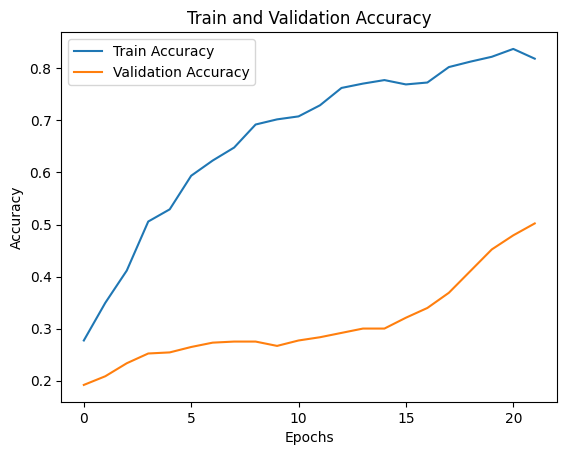

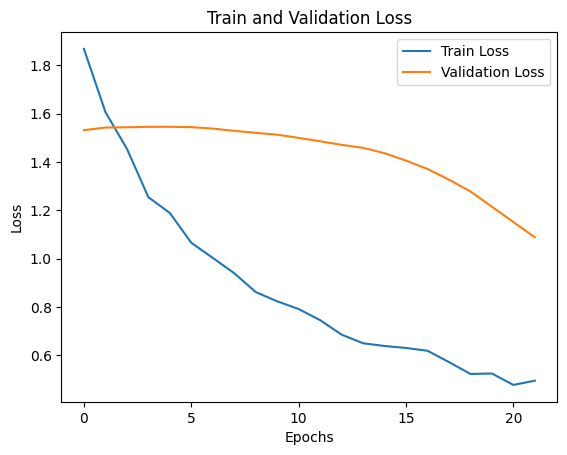

In [30]:
# Afficher l'accuracy et la perte en fonction du nombre d'époques
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

In [31]:
import pickle
import json

# Enregistrer le modèle
best_model.save('../../data/processed/models/notebooks/EffNetB0_MC_finetuned_model.keras')
best_model.save('../../data/processed/models/notebooks/EffNetB0_MC_finetuned_model.h5')

# Enregistrer l'historique
with open('../../data/processed/models/notebooks/EffNetB0_MC_finetuned_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# Enregistrer les métriques dans un fichier JSON
metrics_dict = {
    'loss': history.history['loss'],
    'accuracy': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy']
}

with open('../../data/processed/models/notebooks/EffNetB0_MC_finetuned_metrics.json', 'w') as json_file:
    json.dump(metrics_dict, json_file)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Faire des prédictions sur l'ensemble de données de test
predictions = best_model.predict(x_val)

# Convertir les prédictions en classes (si c'est un problème de classification)
predicted_classes = np.argmax(predictions, axis=1)
y_val_classes = np.argmax(y_val, axis=1)
# Calculer l'accuracy
accuracy = np.mean(predicted_classes == y_val_classes)

print("Accuracy:", accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_val_classes, predicted_classes)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

GRAD-CAM

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "top_conv"

# The local path to our target image
img_path =('../test_images/COVID-231.png')

display(Image(img_path))

In [29]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = best_model

# Remove last layer's softmax
model.layers[-1].activation = None
preds = model.predict(img_array)

# Print the predicted class based on the probability
if preds[0][0] > 0.5:
    print("Predicted: Class 0")
else:
    print("Predicted: Class 1")

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)